# Analyzing Variability in Processing Time and Reporting Bias Across Pittsburgh's 3-1-1 System

### Group Member:Beisi Song, Ziang Wang, Qingyu Zhang, Xindi Shao

<style>
p {
    font-family: "Times New Roman", Times, serif; 
    line-height: 1.5; 
}
h2 {
    font-family: "Times New Roman", Times, serif; 
}
h5 {
    font-family: "Times New Roman", Times, serif; 
}
</style>

## Abstract

Pittsburgh's 3-1-1 system allows residents to report non-emergency issues like potholes, waste, and graffiti which helps municipal service delivery. This study analyzes Pittsburgh's 3-1-1 service request data spanning from 2015 to the present, focusing on exploring variability in request processing times and identifying potential reporting biases. We aim to figure out inequities in how requests are handled across neighborhoods and evaluate whether 3-1-1 requests represent an accurate sample of urban issues.

After cleaning data and using data visualizations, we examined average processing time in different request types and neighborhoods. A regression model was implemented to predict processing time based on request types and neighborhood characteristics. Our analysis highlights differences in service fulfillment time and variability between neighborhoods, providing insights into inequities in city response time.

To determine if there is reporting bias, we compared 3-1-1 data with complementary datasets, including building code violations and vacant property reports and then examined if similar patterns of reporting are observed across neighborhoods. This comparison tests the assumption that 3-1-1 data accurately reflects underlying issues, such as pothole prevalence or code violations within the city.

Our findings contribute to the understanding of fairness in city services, address potential biases in reporting systems, and provide practical ideas for improving how the city responds to citizen requests. By combining data from different sources, this study helps guide resource distribution to make city services more fair and balanced for all residents.


## Data sources:

- [311 Data](https://data.wprdc.org/dataset/311-data)
- [2020 Census Redistricting Data Extracts (PL 94-171)](https://data.wprdc.org/dataset/2020-census-redistricting-data-extracts)
- [neighborhood shapefile](https://data.wprdc.org/dataset/neighborhoods2)


In [32]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 18.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning  

We only select neighborhoods in Pittsburgh and Wilkinsburg outside Pittsburgh because it shares the resources like trash and fire service with Pittsburgh.  

Delete all the types with **"DO NOT USE"**.  

Delete all the requests with **NA neighborhood**.  


In [2]:
# load the dataset and columns with interest
addataset = '311_data.csv'
request = pd.read_csv(addataset)

In [3]:
request

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,cross_street_id,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy
0,1,827262,1,f,open,0,DPW - Administration,Park Shelter,543,2024-03-12T10:50:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES
1,2,720661,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-20T07:52:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES
2,3,722010,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-24T07:44:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES
3,4,846915,1,f,open,0,Police - Zones 1-6,Illegal Parking,417,2024-05-19T12:24:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES
4,5,853708,1,f,open,0,DPW - Facilities,City Facility,375,2024-06-06T23:04:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791525,791559,903365,1,f,open,0,311,Mayor's Office,281,2024-11-14T17:02:00,...,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
791526,791560,903381,1,f,open,0,Sargent Electric,Street Light - Repair,8715,2024-11-14T18:47:00,...,11327.0,Pittsburgh,Lower Lawrenceville,NaN,7.0,6.0,2.0,40.468266,-79.962813,EXACT
791527,791561,903380,1,f,open,0,Sargent Electric,Street Light - Repair,8715,2024-11-14T18:42:00,...,0.0,Pittsburgh,Lower Lawrenceville,NaN,7.0,6.0,2.0,40.465077,-79.965440,EXACT
791528,791562,903378,1,f,open,0,DPW - Refuse,Missed Refuse Pick Up,507,2024-11-14T18:20:00,...,NaN,Pittsburgh,Brighton Heights,4.200327e+10,1.0,27.0,1.0,40.479691,-80.027673,APPROXIMATE


In [9]:
# delete all the "DO NOT USE" type
request = request[~request['request_type_name'].str.contains('DO NOT USE', na=False)]

In [10]:
# Filter data to only include rows where city is Pittsburgh or Wilkinsburg
filtered_request = request[request['city'].isin(['Pittsburgh', 'Wilkinsburg'])]

# Check the filtered data
print(filtered_request.head())

   _id  group_id  num_requests parent_closed status_name  status_code  \
0    1    827262             1             f        open            0   
1    2    720661             1             f        open            0   
2    3    722010             1             f        open            0   
3    4    846915             1             f        open            0   
4    5    853708             1             f        open            0   

                   dept request_type_name  request_type_id  \
0  DPW - Administration      Park Shelter              543   
1  DPW - Administration      Park Shelter              543   
2  DPW - Administration      Park Shelter              543   
3    Police - Zones 1-6   Illegal Parking              417   
4      DPW - Facilities     City Facility              375   

        create_date_et  ... cross_street_id        city neighborhood  \
0  2024-03-12T10:50:00  ...             NaN  Pittsburgh          NaN   
1  2023-03-20T07:52:00  ...             NaN 

In [11]:
filtered_request.isna().sum()

_id                       0
group_id                  0
num_requests              0
parent_closed             0
status_name               0
status_code               0
dept                   4048
request_type_name         0
request_type_id           0
create_date_et            0
create_date_utc           0
last_action_et            0
last_action_utc           0
closed_date_et        91035
closed_date_utc       91035
origin                    0
street               302734
cross_street         689025
street_id            296324
cross_street_id      296324
city                      0
neighborhood          34882
census_tract         212571
council_district      33470
ward                  34723
police_zone           34969
latitude              29005
longitude             29005
geo_accuracy              0
dtype: int64

In [12]:
# delete na values
filtered_request= filtered_request[filtered_request['neighborhood'].notna()]

print("After cleaning the data:")
print(filtered_request.head())

After cleaning the data:
     _id  group_id  num_requests parent_closed  status_name  status_code  \
96    97    626501             1             f         open            0   
196  197    432038             1             f  in progress            3   
309  310    577909             1             f  in progress            3   
375  376    620792             1             f         open            0   
529  530    320982             1             f         open            0   

                       dept                     request_type_name  \
96       Police - Zones 1-6          Excessive Noise/Disturbances   
196      Police - Zones 1-6               Graffiti, Documentation   
309  DPW - Park Maintenance                                 Field   
375            Police - AVU  Abandoned Vehicle (parked on street)   
529          DOMI - Permits           Blocked or Closed Sidewalks   

     request_type_id       create_date_et  ... cross_street_id        city  \
96               297  202

## Are Requests Being Fulfilled?  

For the first problem: **Look at whether requests are fulfilled**, we found that there are **four types of request status**. We use the **closed ratio** (closed requests / total requests) for each neighborhood to determine whether requests are being fulfilled.  


In [16]:
# calculate the number of each status_code
status_code_counts = filtered_request['status_code'].value_counts().reset_index()
status_code_counts.columns = ['status_code', 'count']

# combine
unique_status = filtered_request[['status_code', 'status_name']].drop_duplicates()
status_code_summary = unique_status.merge(status_code_counts, on='status_code', how='left')

print("Unique status codes, their corresponding names, and counts:")
print(status_code_summary)


Unique status codes, their corresponding names, and counts:
   status_code  status_name   count
0            0         open   39495
1            3  in progress   46542
2            1       closed  667999
3            4      on hold     427


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\2379490867.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


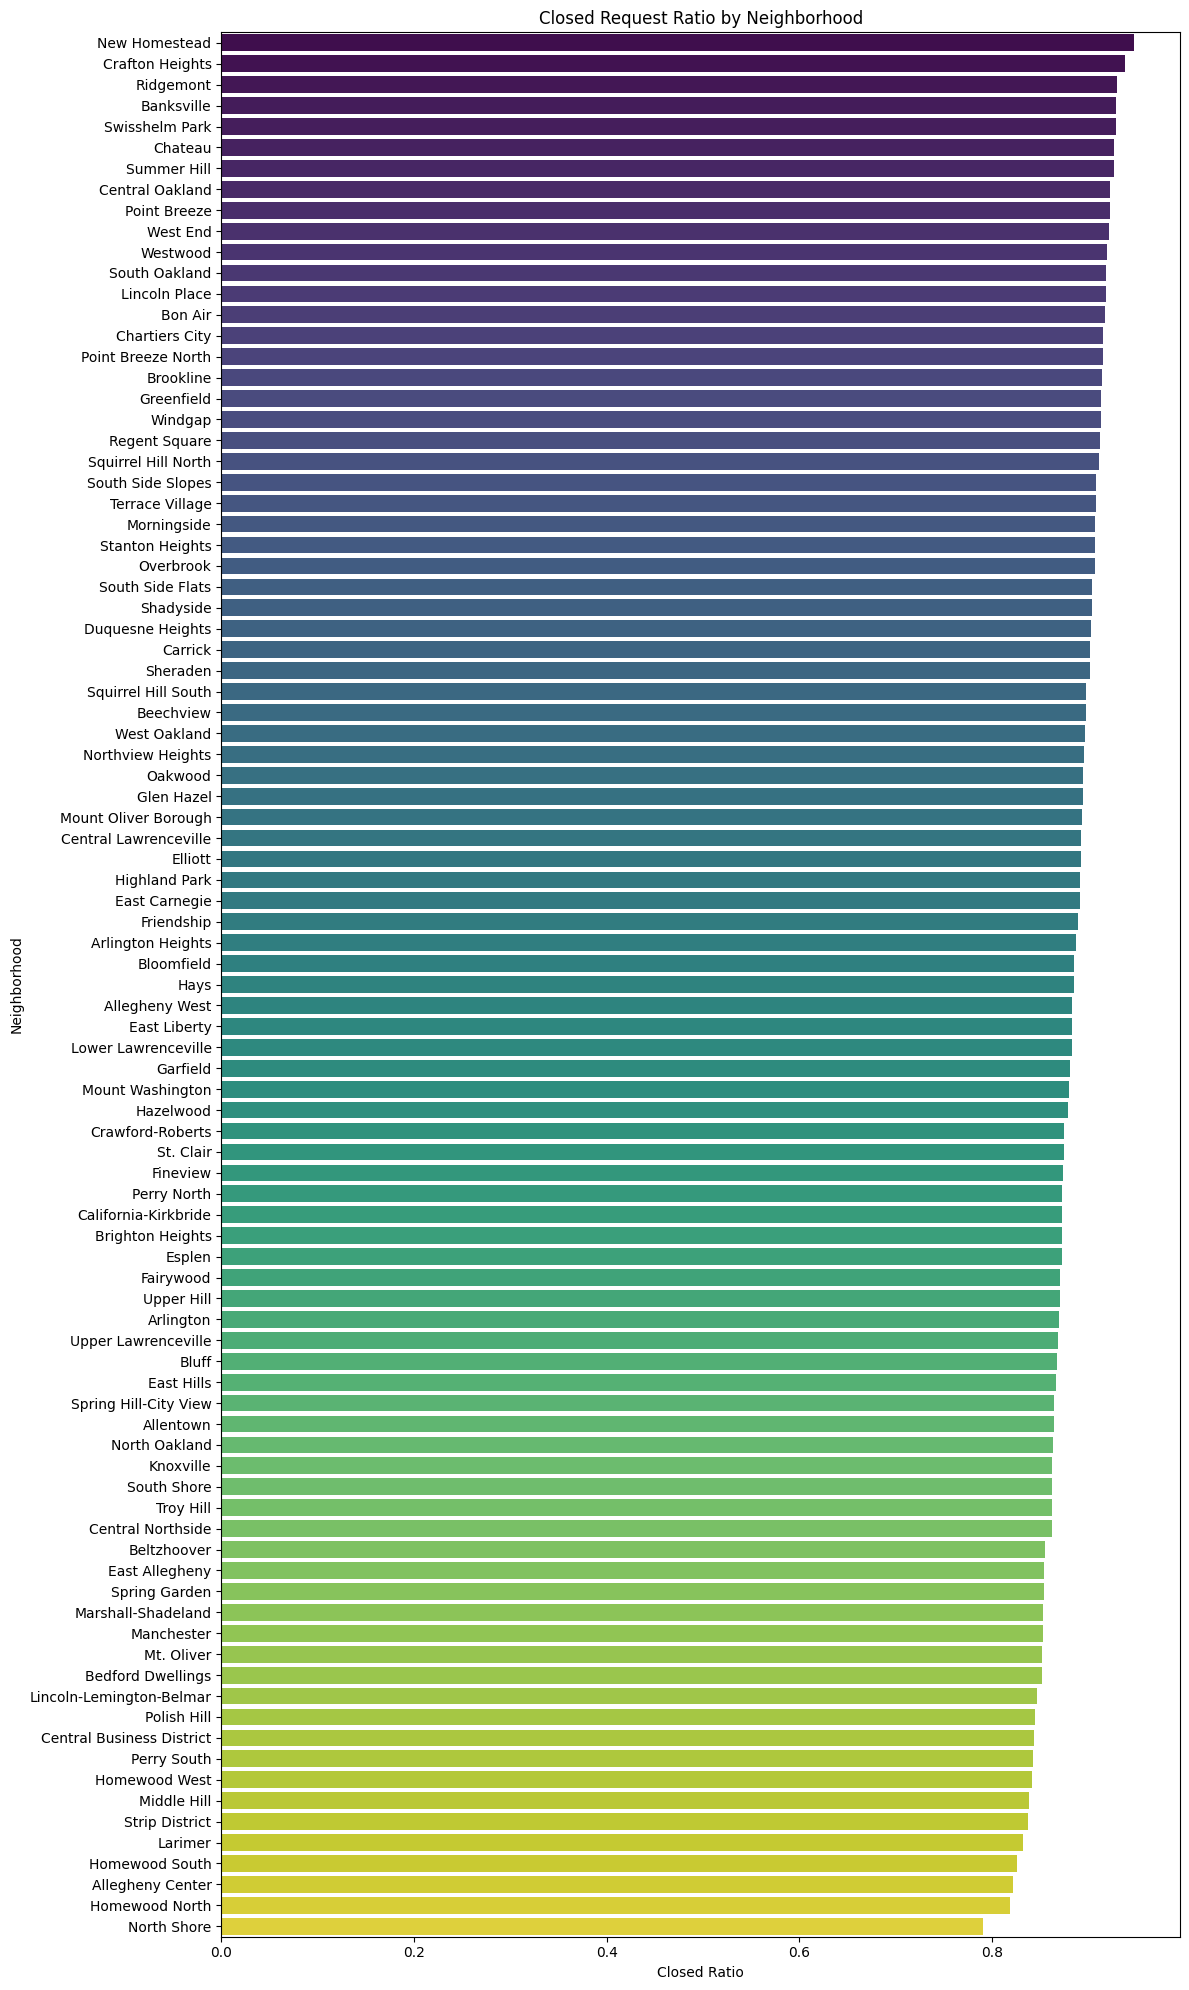

In [17]:
# Calculate close ratio

# select the record with 'Closed'
closed_status = filtered_request[filtered_request['status_code'] == 1]

# calculate the number of closed request in each neighborhood 
closed_counts = closed_status.groupby('neighborhood')['status_code'].count().reset_index()
closed_counts.columns = ['neighborhood', 'closed_count']

# calculate the total request number in each neighborhood
total_counts = filtered_request.groupby('neighborhood')['status_code'].count().reset_index()
total_counts.columns = ['neighborhood', 'total_count']

# calculate the propotion of closed request in each neighborhood
neighborhood_closed_stats = pd.merge(closed_counts, total_counts, on='neighborhood')
neighborhood_closed_stats['closed_ratio'] = neighborhood_closed_stats['closed_count'] / neighborhood_closed_stats['total_count']

# plot the histogram of closed ratio in different neighborhood
plt.figure(figsize=(12, 20))
sns.barplot(
    data=neighborhood_closed_stats.sort_values(by='closed_ratio', ascending=False),
    x='closed_ratio',
    y='neighborhood',
    palette='viridis'
)
plt.title('Closed Request Ratio by Neighborhood')
plt.xlabel('Closed Ratio')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1991010556.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


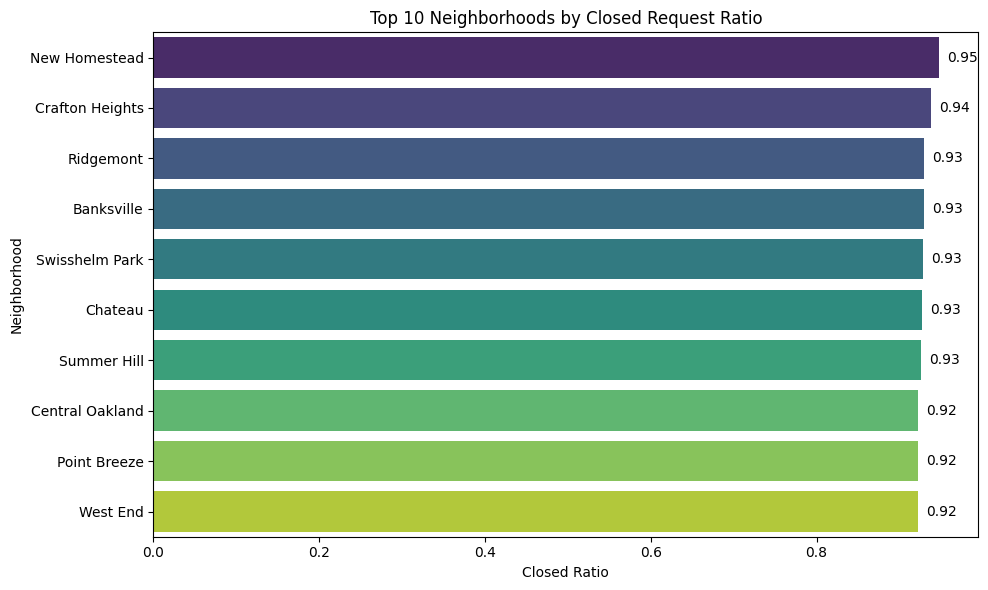

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1991010556.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


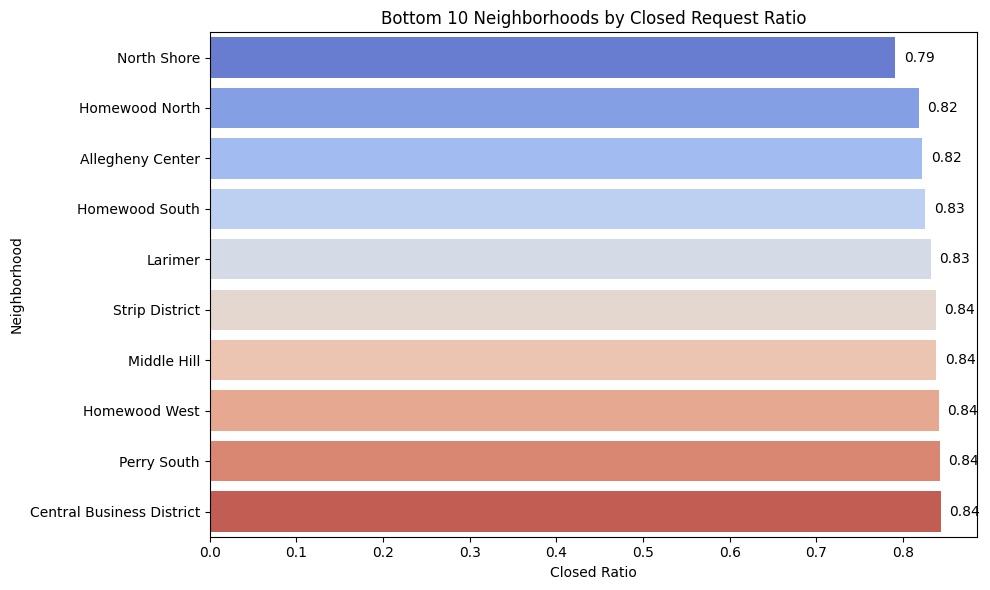

In [85]:
# Visualize top 10 neighborhoods by closed ratio
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_neighborhoods.sort_values(by='closed_ratio', ascending=False),
    x='closed_ratio',
    y='neighborhood',
    palette='viridis'
)
plt.title('Top 10 Neighborhoods by Closed Request Ratio')
plt.xlabel('Closed Ratio')
plt.ylabel('Neighborhood')

# Adjust label positions for top 10
for index, row in enumerate(top_10_neighborhoods.sort_values(by='closed_ratio', ascending=False).itertuples()):
    plt.text(
        row.closed_ratio + 0.01,  # Move the text slightly beyond the bar
        index,  # Use the y-axis position of the bar
        f"{row.closed_ratio:.2f}",  # Format the closed ratio
        va='center',  # Vertical alignment
        color='black'  # Text color
    )

plt.tight_layout()
plt.show()

# Visualize bottom 10 neighborhoods by closed ratio
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom_10_neighborhoods.sort_values(by='closed_ratio', ascending=True),
    x='closed_ratio',
    y='neighborhood',
    palette='coolwarm'
)
plt.title('Bottom 10 Neighborhoods by Closed Request Ratio')
plt.xlabel('Closed Ratio')
plt.ylabel('Neighborhood')

# Adjust label positions for bottom 10
for index, row in enumerate(bottom_10_neighborhoods.sort_values(by='closed_ratio', ascending=True).itertuples()):
    plt.text(
        row.closed_ratio + 0.01,  # Move the text slightly beyond the bar
        index,  # Use the y-axis position of the bar
        f"{row.closed_ratio:.2f}",  # Format the closed ratio
        va='center',  # Vertical alignment
        color='black'  # Text color
    )

plt.tight_layout()
plt.show()



## Results: High Overall Fulfillment Rates  

- Most neighborhoods achieve a **high closed request ratio**, with the lowest neighborhood reaching **0.79**.  

- The **Top 10 neighborhoods** have closed ratios ranging from **0.92 to 0.94**.  

- The **Bottom 10 neighborhoods** have closed ratios ranging from **0.79 to 0.88**.  

- The difference between the top and bottom neighborhoods in closed request ratio is **not drastic** (only **0.15**), suggesting **consistent service delivery** across most areas.  


## Data Visualization: Heatmap  

Directly observing the distribution of neighborhoods through a histogram does not provide an optimal visualization. Therefore, we imported the **neighborhood shapefile** and mapped the **closed ratio** for each neighborhood onto a geographic map to achieve a **more intuitive data visualization**.  



In [319]:
!pip install geopandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
# load the shape file
import geopandas as gpd
neighborhoods_gdf = gpd.read_file("Neighborhoods_.shp")


In [21]:
from shapely.geometry import Point
# transfer requests to GeoDataFrame
filtered_request['geometry'] = filtered_request.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
filtered_request_gdf = gpd.GeoDataFrame(filtered_request, geometry='geometry', crs='EPSG:4326')

# Make sure the coordinate systems of the two are consistent
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=4326)

# Use spatial join to match complaint points to communities
request_with_neighborhood = gpd.sjoin(filtered_request_gdf, neighborhoods_gdf, how='left', predicate='intersects')

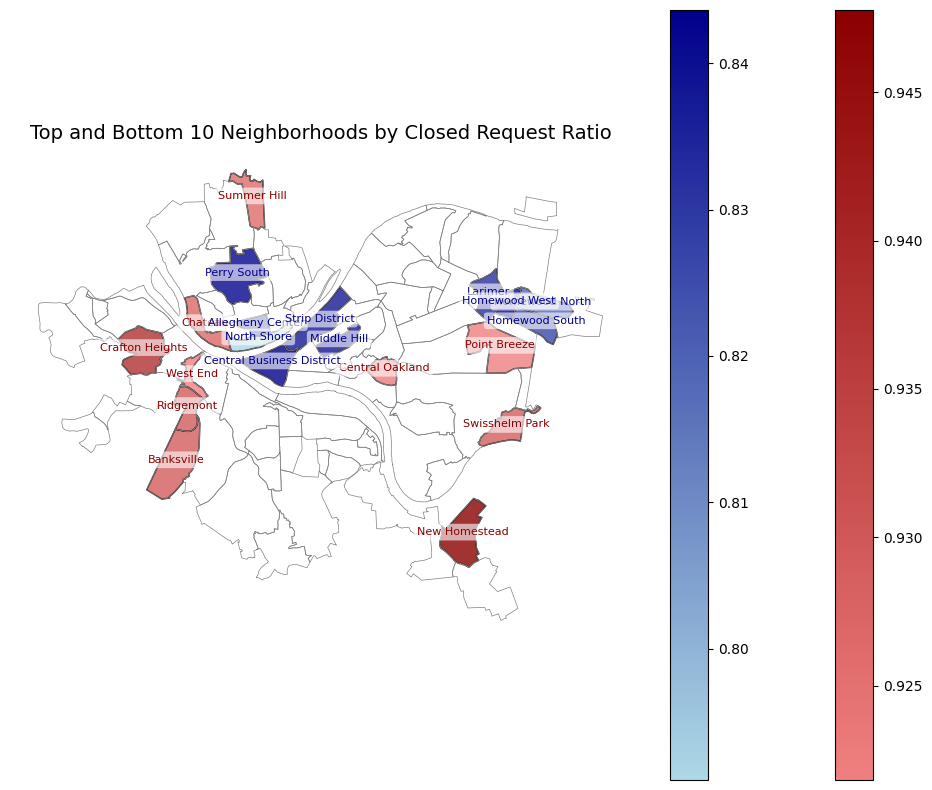

In [24]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Merge the selected neighborhoods with the GeoDataFrame
top_10_geo = neighborhoods_gdf.merge(top_10_neighborhoods, left_on='hood', right_on='neighborhood', how='inner')
bottom_10_geo = neighborhoods_gdf.merge(bottom_10_neighborhoods, left_on='hood', right_on='neighborhood', how='inner')

# Step 2: Define custom colormaps
top_colormap = LinearSegmentedColormap.from_list("TopColormap", ["lightcoral", "darkred"])
bottom_colormap = LinearSegmentedColormap.from_list("BottomColormap", ["lightblue", "darkblue"])

# Step 3: Plot a combined map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot all neighborhoods' boundaries in gray for context
neighborhoods_gdf.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Plot Top 10 neighborhoods with the custom red gradient
top_10_geo.plot(
    column='closed_ratio',  # Column used for coloring
    cmap=top_colormap,      # Custom red gradient colormap
    legend=True,            # Show legend for the top 10
    ax=ax,                  # Plot on the combined map
    edgecolor='black',      # Add black borders to polygons
    alpha=0.8               # Slight transparency for better layering
)

# Plot Bottom 10 neighborhoods with the custom blue gradient
bottom_10_geo.plot(
    column='closed_ratio',  # Column used for coloring
    cmap=bottom_colormap,   # Custom blue gradient colormap
    legend=True,            # Show legend for the bottom 10
    ax=ax,                  # Plot on the combined map
    edgecolor='black',      # Add black borders to polygons
    alpha=0.8               # Slight transparency for better layering
)

# Annotate neighborhood names for the top 10
for idx, row in top_10_geo.iterrows():
    ax.annotate(
        text=row['neighborhood'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
        fontsize=8, color='darkred', ha='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.6)
    )

# Annotate neighborhood names for the bottom 10
for idx, row in bottom_10_geo.iterrows():
    ax.annotate(
        text=row['neighborhood'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
        fontsize=8, color='darkblue', ha='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.6)
    )

# Add a title
ax.set_title('Top and Bottom 10 Neighborhoods by Closed Request Ratio', fontsize=14)

# Turn off axis for a cleaner look
ax.set_axis_off()

# Show the map
plt.tight_layout()
plt.show()


## Results  

- **Neighborhoods with high closed request ratios** (in red) are geographically dispersed across Pittsburgh.  

- **Neighborhoods with low closed request ratios** (in blue) are clustered in two distinct areas:  
  - The **Homewood region**  
  - The **downtown and surrounding areas**  

- These areas need **additional resources**.  


## Calculate the processing time for each request

In [28]:
# Analysis processing time with those closed requests
# only select status code = 1, closed data
closed_requests = filtered_request[filtered_request['status_code'] == 1]

In [29]:
print(closed_requests.head())

       _id  group_id  num_requests parent_closed status_name  status_code  \
1916  1917    364683             1             t      closed            1   
2268  2269    609425             1             t      closed            1   
2940  2941    522984             1             t      closed            1   
3222  3223    649283             1             t      closed            1   
4123  4124    645562             1             t      closed            1   

                         dept          request_type_name  request_type_id  \
1916        DOMI - Structures  Building Without a Permit              436   
2268        DOMI - Structures         Bridge Maintenance            24077   
2940        DOMI - Structures    Retaining Wall (Public)              821   
3222  DPW - Forestry Division        Pruning (city tree)              520   
4123  DPW - Forestry Division        Pruning (city tree)              520   

           create_date_et  ...        city      neighborhood  census_tract

In [30]:
closed_requests.isna().sum()

_id                       0
group_id                  0
num_requests              0
parent_closed             0
status_name               0
status_code               0
dept                   2343
request_type_name         0
request_type_id           0
create_date_et            0
create_date_utc           0
last_action_et            0
last_action_utc           0
closed_date_et            0
closed_date_utc           0
origin                    0
street               230825
cross_street         574130
street_id            228335
cross_street_id      228335
city                      0
neighborhood              0
census_tract         151782
council_district        182
ward                     45
police_zone             203
latitude                 15
longitude                15
geo_accuracy              0
geometry                  0
dtype: int64

In [31]:
# transfer date data type to datetime form
closed_requests['create_date_et'] = pd.to_datetime(closed_requests['create_date_et'])
closed_requests['closed_date_et'] = pd.to_datetime(closed_requests['closed_date_et'])

# calculate processing time
closed_requests['processing_time'] = (closed_requests['closed_date_et'] - closed_requests['create_date_et']).dt.total_seconds() / 86400  
print(closed_requests[['create_date_et', 'closed_date_et', 'processing_time']].head())


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1719188622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_requests['create_date_et'] = pd.to_datetime(closed_requests['create_date_et'])


          create_date_et      closed_date_et  processing_time
1916 2019-07-25 08:09:00 2024-11-07 10:04:00      1932.079861
2268 2022-02-16 08:23:00 2024-11-14 17:39:00      1002.386111
2940 2021-05-13 09:03:00 2024-11-01 14:20:00      1268.220139
3222 2022-06-26 10:30:00 2024-10-08 07:49:00       834.888194
4123 2022-06-15 10:45:00 2024-11-08 09:40:00       876.954861


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1719188622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_requests['closed_date_et'] = pd.to_datetime(closed_requests['closed_date_et'])
C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1719188622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_requests['processing_time'] = (closed_requests['closed_date_et'] - closed_requests['create_date_et']).dt.total_seconds() / 86400


In [32]:
# output the file
output_file = 'processed_311_data.csv'
closed_requests.to_csv(output_file, index=False)

## How Long 311 Calls Take to Be Completed  

After that, we continued to analyze the **processing time**. We calculated the **average processing time** for each neighborhood and selected the **top 10** and **bottom 10** neighborhoods for clearer visualization. We also plotted the **heatmap** for all neighborhoods.  


In [33]:
# Processing Time Analysis---Data Visulization

In [44]:
# group by neighborhood and calculate the average processing_time
closed_requests=pd.read_csv('processed_311_data.csv')
neighborhood_avg_processing_time = closed_requests.groupby('neighborhood')['processing_time'].mean().reset_index()
neighborhood_avg_processing_time.columns = ['neighborhood', 'avg_processing_time']

# print the result
print(neighborhood_avg_processing_time.head())

        neighborhood  avg_processing_time
0   Allegheny Center           125.008088
1     Allegheny West            93.052154
2          Allentown           103.529461
3          Arlington            81.258323
4  Arlington Heights            65.923924


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\3956868817.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


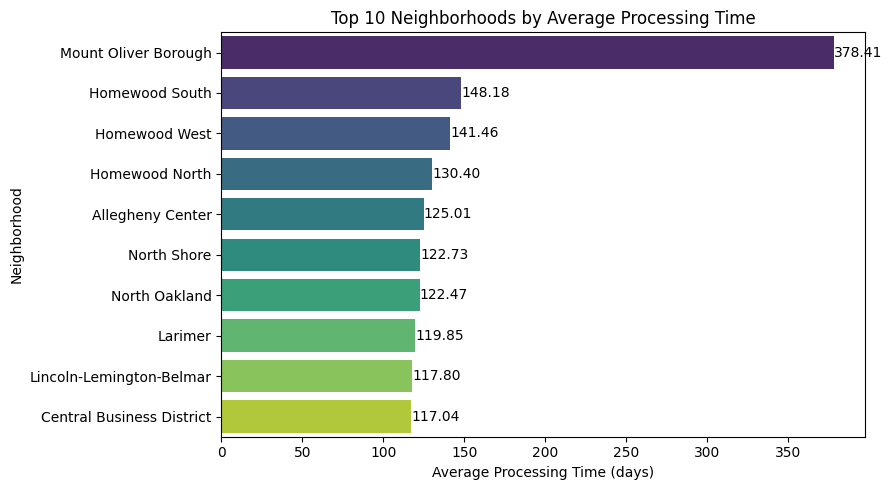

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\3956868817.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


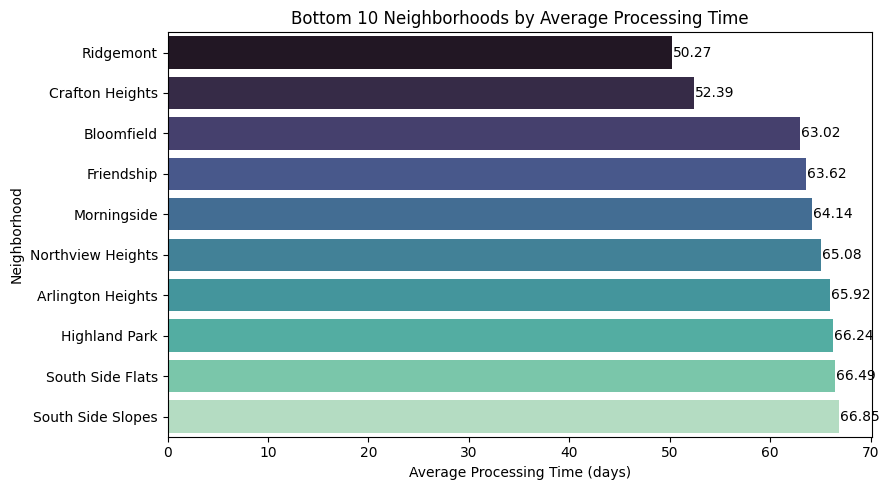

In [46]:
# Filter top 10 neighborhoods by average processing time
top_10_neighborhoods_avg_time = neighborhood_avg_processing_time.sort_values(by='avg_processing_time', ascending=False).head(10)

# Plot the histogram for top 10 neighborhoods
plt.figure(figsize=(9, 5))
sns.barplot(
    data=top_10_neighborhoods_avg_time,
    x='avg_processing_time',
    y='neighborhood',
    palette='viridis'
)
plt.title('Top 10 Neighborhoods by Average Processing Time')
plt.xlabel('Average Processing Time (days)')
plt.ylabel('Neighborhood')

# Add average processing time labels on the bars
for index, row in enumerate(top_10_neighborhoods_avg_time.itertuples()):
    plt.text(row.avg_processing_time + 0.1, index, f"{row.avg_processing_time:.2f}", va='center', color='black')

plt.tight_layout()
plt.show()

# Filter bottom 10 neighborhoods by average processing time
bottom_10_neighborhoods_avg_time = neighborhood_avg_processing_time.sort_values(by='avg_processing_time', ascending=True).head(10)

# Plot the histogram for bottom 10 neighborhoods
plt.figure(figsize=(9, 5))
sns.barplot(
    data=bottom_10_neighborhoods_avg_time,
    x='avg_processing_time',
    y='neighborhood',
    palette='mako'
)
plt.title('Bottom 10 Neighborhoods by Average Processing Time')
plt.xlabel('Average Processing Time (days)')
plt.ylabel('Neighborhood')

# Add average processing time labels on the bars
for index, row in enumerate(bottom_10_neighborhoods_avg_time.itertuples()):
    plt.text(row.avg_processing_time + 0.1, index, f"{row.avg_processing_time:.2f}", va='center', color='black')

plt.tight_layout()
plt.show()


#### <span style="color:red">Note</span>  

Although Mount Oliver Borough is surrounded entirely by the city of Pittsburgh, it is an independent municipality. It's hard for the government of Pittsburgh to solve requests from Mt. Oliver.  

We **ignore this neighborhood** for the following analysis.  


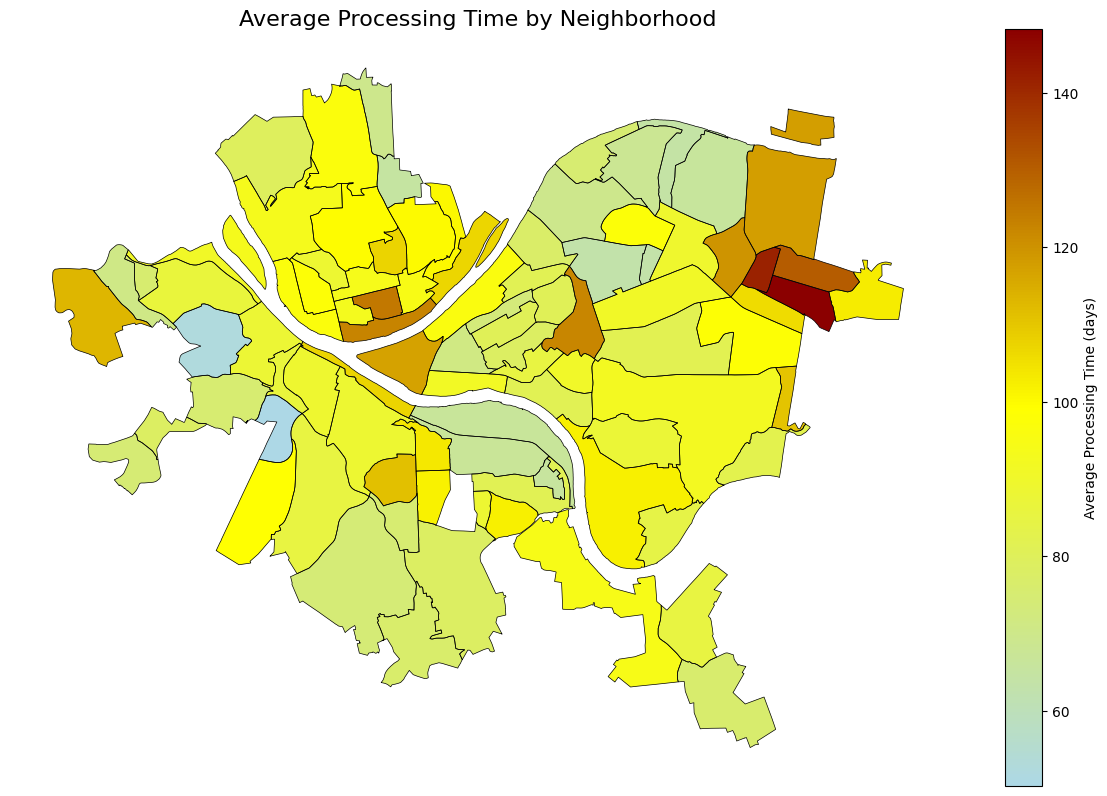

In [332]:
# heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Merge average processing time data with neighborhood boundaries
merged_gdf = neighborhoods_gdf.merge(neighborhood_avg_processing_time,left_on='hood', right_on='neighborhood', how='inner' )

# Step 2: Create a colormap
full_colormap = LinearSegmentedColormap.from_list('ProcessingTime', ['lightblue', 'yellow', 'darkred'])

# Step 3: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot all neighborhoods as a heatmap using raw average processing time
merged_gdf.plot(
    column='avg_processing_time',
    cmap=full_colormap,
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "Average Processing Time (days)", 
        'orientation': 'vertical'
    }
)

# Plot neighborhood boundaries for reference
neighborhoods_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Title and layout adjustments
plt.title("Average Processing Time by Neighborhood", fontsize=16)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()



## Result
Here is the heatmap of that. It shares some similar features with the **closed ratio**. The areas of **Homewood** and **downtown** also show high average processing times.  

We aim to investigate whether there are **inequalities among regions**. Specifically, we want to determine if the high average processing times in these neighborhoods are due to **less attention and response** or **the nature of the request type**.  


In [63]:
# Remove rows where the neighborhood is "Mount Oliver Borough"
model_request_data = closed_requests[closed_requests['neighborhood'] != 'Mount Oliver Borough']

# Export the model_request_data to a CSV file
model_request_data.to_csv('model_request_data.csv', index=False)

## Standard Deviation Analysis  

We did not include this in the final report, but we conducted the analysis, and the results are presented below.  

We analyzed and visualized the **standard deviation** of the processing time for each neighborhood. A **box plot** was created to show the distribution and variability of processing times across neighborhoods.  

This analysis helps identify neighborhoods with high variability in processing times, which could indicate inconsistencies in service delivery. Such insights can guide future investigations into the underlying reasons for these inconsistencies, such as differences in request types or resource allocation.  



In [ ]:
# Standard Deviation Analysis

In [4]:
closed_requests=pd.read_csv('model_request_data.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\4136620611.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


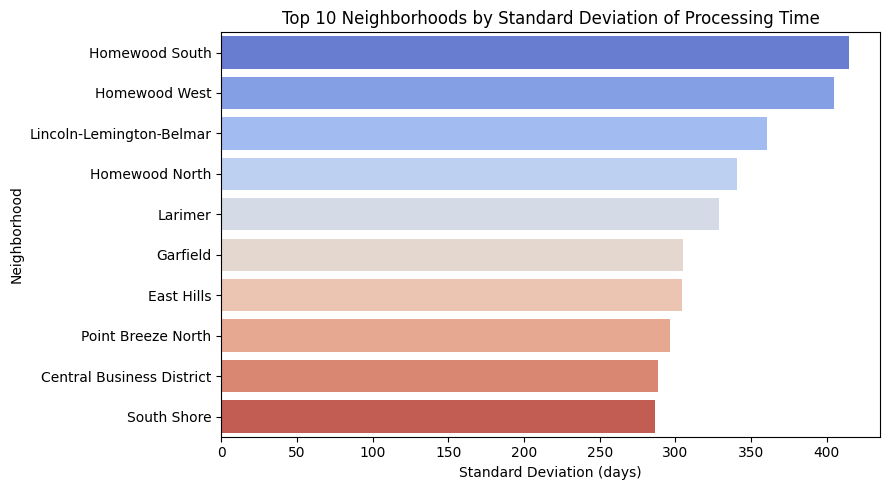

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\4136620611.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


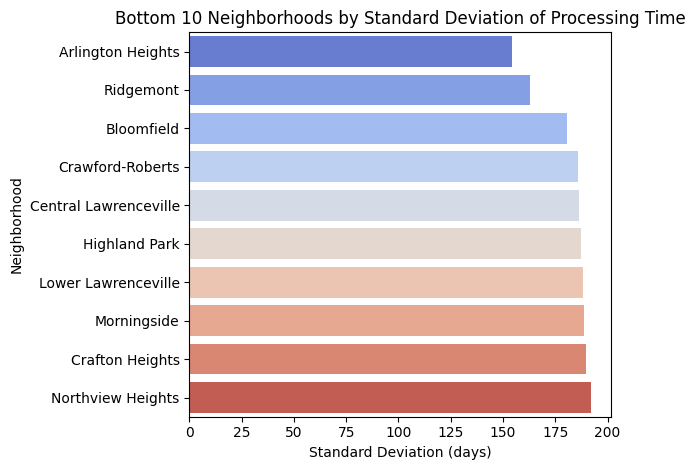

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the mean and standard deviation of processing time by neighborhood
neighborhood_stats = closed_requests.groupby('neighborhood')['processing_time'].agg(['mean', 'std']).reset_index()
neighborhood_stats.columns = ['neighborhood', 'mean_processing_time', 'std_processing_time']

# Step 2: Get top 10 neighborhoods by standard deviation
top_10_std_neighborhoods = neighborhood_stats.sort_values(by='std_processing_time', ascending=False).head(10)

# Step 3: Get bottom 10 neighborhoods by standard deviation
bottom_10_std_neighborhoods = neighborhood_stats.sort_values(by='std_processing_time', ascending=True).head(10)

# Step 4: Plot top 10 neighborhoods by standard deviation
plt.figure(figsize=(9, 5))
sns.barplot(
    data=top_10_std_neighborhoods.sort_values(by='std_processing_time', ascending=False),
    x='std_processing_time',
    y='neighborhood',
    palette='coolwarm'
)
plt.title('Top 10 Neighborhoods by Standard Deviation of Processing Time')
plt.xlabel('Standard Deviation (days)')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

# Step 5: Plot bottom 10 neighborhoods by standard deviation
plt.figure(figure=(9, 5))
sns.barplot(
    data=bottom_10_std_neighborhoods.sort_values(by='std_processing_time', ascending=True),
    x='std_processing_time',
    y='neighborhood',
    palette='coolwarm'
)
plt.title('Bottom 10 Neighborhoods by Standard Deviation of Processing Time')
plt.xlabel('Standard Deviation (days)')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()


In [68]:
# Step 1: Calculate range and quartiles
def calculate_range_and_quartiles(data, column):
    quartiles = data.groupby('neighborhood')[column].quantile([0.25, 0.5, 0.75]).unstack()
    quartiles.columns = ['Q1', 'Median', 'Q3']
    quartiles['Range'] = data.groupby('neighborhood')[column].max() - data.groupby('neighborhood')[column].min()
    return quartiles

# Step 2: Filter top 10 and bottom 10 neighborhoods by mean processing time
neighborhood_stats = closed_requests.groupby('neighborhood')['processing_time'].agg(['mean']).reset_index()
neighborhood_stats.columns = ['neighborhood', 'mean_processing_time']

# Get Top 10 and Bottom 10 neighborhoods
top_10_neighborhoods = neighborhood_stats.sort_values(by='mean_processing_time', ascending=False).head(10)
bottom_10_neighborhoods = neighborhood_stats.sort_values(by='mean_processing_time', ascending=True).head(10)

# Step 3: Calculate quartiles and range for Top 10 neighborhoods
top_10_data = closed_requests[closed_requests['neighborhood'].isin(top_10_neighborhoods['neighborhood'])]
top_10_quartiles = calculate_range_and_quartiles(top_10_data, 'processing_time')
top_10_quartiles['Neighborhood'] = top_10_quartiles.index

# Step 4: Calculate quartiles and range for Bottom 10 neighborhoods
bottom_10_data = closed_requests[closed_requests['neighborhood'].isin(bottom_10_neighborhoods['neighborhood'])]
bottom_10_quartiles = calculate_range_and_quartiles(bottom_10_data, 'processing_time')
bottom_10_quartiles['Neighborhood'] = bottom_10_quartiles.index


Top 10 Neighborhoods - Quartiles and Range:
                                 Q1     Median         Q3        Range  \
neighborhood                                                             
Allegheny Center           1.745139   9.877778  76.103472  2361.954861   
Central Business District  1.536806   7.647222  59.109722  3010.263889   
Fairywood                  2.036458   9.904514  51.645139  1861.618750   
Homewood North             2.139236  14.018403  88.120486  3093.002778   
Homewood South             2.006250  13.697917  84.001736  3094.892361   
Homewood West              1.968576  13.825000  84.969792  3076.947222   
Larimer                    2.678472  14.848611  81.220139  3088.061111   
Lincoln-Lemington-Belmar   1.633333   9.188889  62.961806  3130.839583   
North Oakland              2.622743  11.080208  70.965104  2750.734722   
North Shore                1.780729   7.926389  64.136632  1762.027778   

                                        Neighborhood  
neighborhood

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\3589133618.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


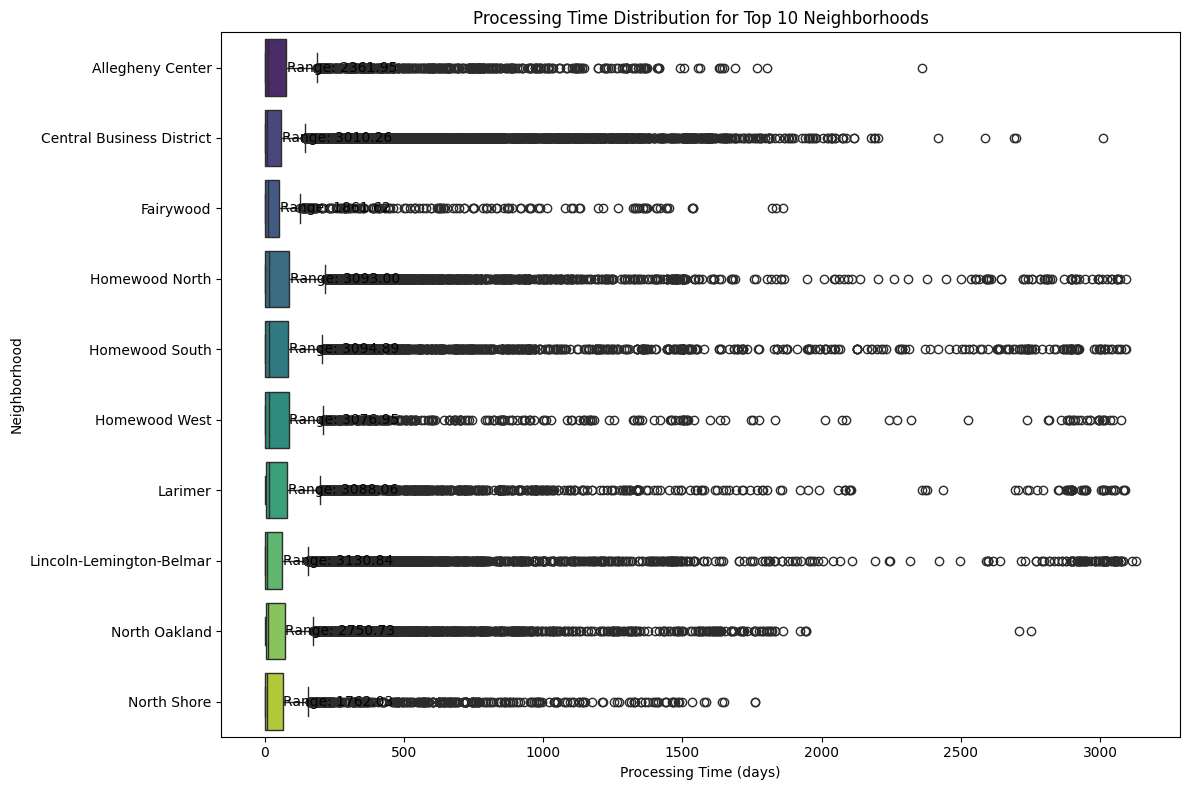

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\3589133618.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


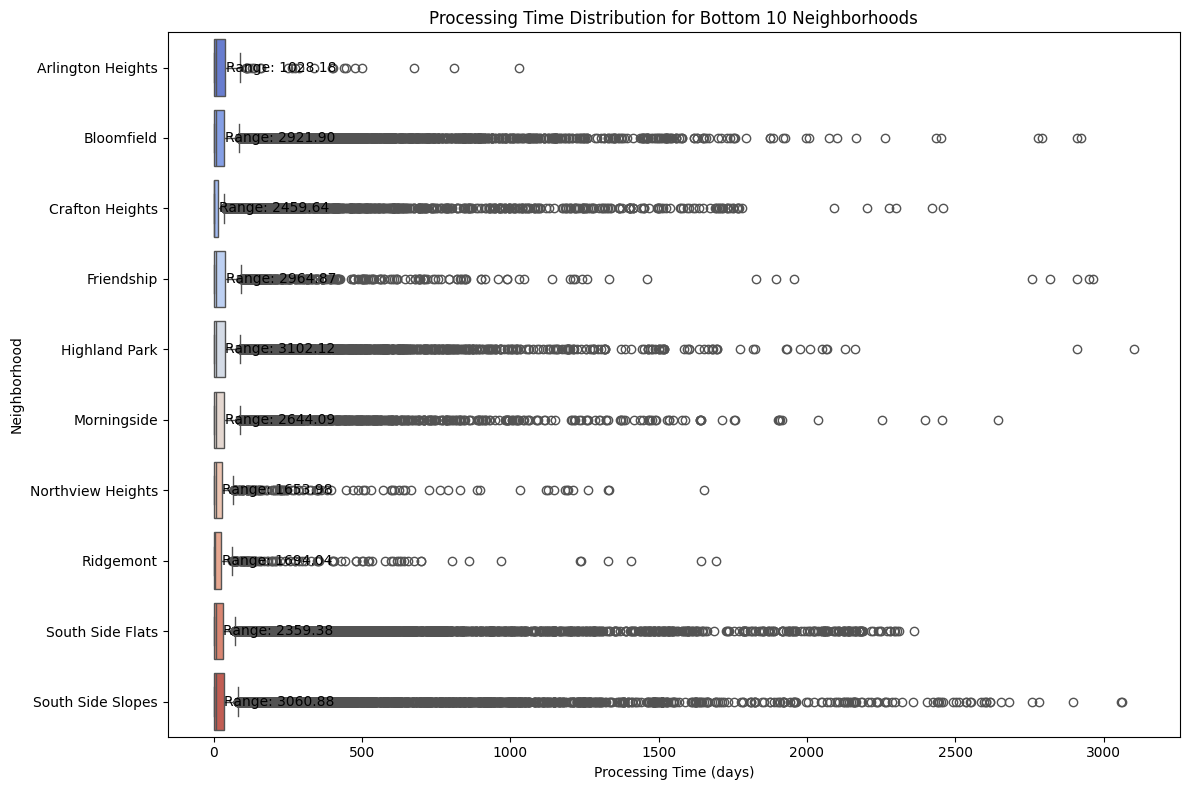

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Top 10 Neighborhoods
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=top_10_data,
    x='processing_time',
    y='neighborhood',
    palette='viridis',
    order=top_10_quartiles['Neighborhood']  
)
plt.title('Processing Time Distribution for Top 10 Neighborhoods')
plt.xlabel('Processing Time (days)')
plt.ylabel('Neighborhood')

# Add text annotations for quartiles and range
for index, row in top_10_quartiles.iterrows():
    plt.text(row['Q3'] + 2, index, f"Range: {row['Range']:.2f}", va='center', color='black')

plt.tight_layout()
plt.show()

# Plot Bottom 10 Neighborhoods
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=bottom_10_data,
    x='processing_time',
    y='neighborhood',
    palette='coolwarm',
    order=bottom_10_quartiles['Neighborhood']
)
plt.title('Processing Time Distribution for Bottom 10 Neighborhoods')
plt.xlabel('Processing Time (days)')
plt.ylabel('Neighborhood')

# Add text annotations for quartiles and range
for index, row in bottom_10_quartiles.iterrows():
    plt.text(row['Q3'] + 2, index, f"Range: {row['Range']:.2f}", va='center', color='black')

plt.tight_layout()
plt.show()


## Processing Time Analysis by Type

In [ ]:
# Processing Time Analysis by Requeat Type

In [70]:
# group by request type and calculate the average processing_time
type_avg_processing_time = closed_requests.groupby('request_type_name')['processing_time'].mean().reset_index()
type_avg_processing_time.columns = ['request_type_name', 'avg_processing_time']

# print the result
print(type_avg_processing_time.head())

                      request_type_name  avg_processing_time
0                       911 Performance             1.410044
1                ADA Ramp, Installation           243.856800
2                     Abandoned Vehicle           196.630141
3  Abandoned Vehicle (parked on street)           185.892680
4      Accessibility Construction Issue           284.414815


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\30836470.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


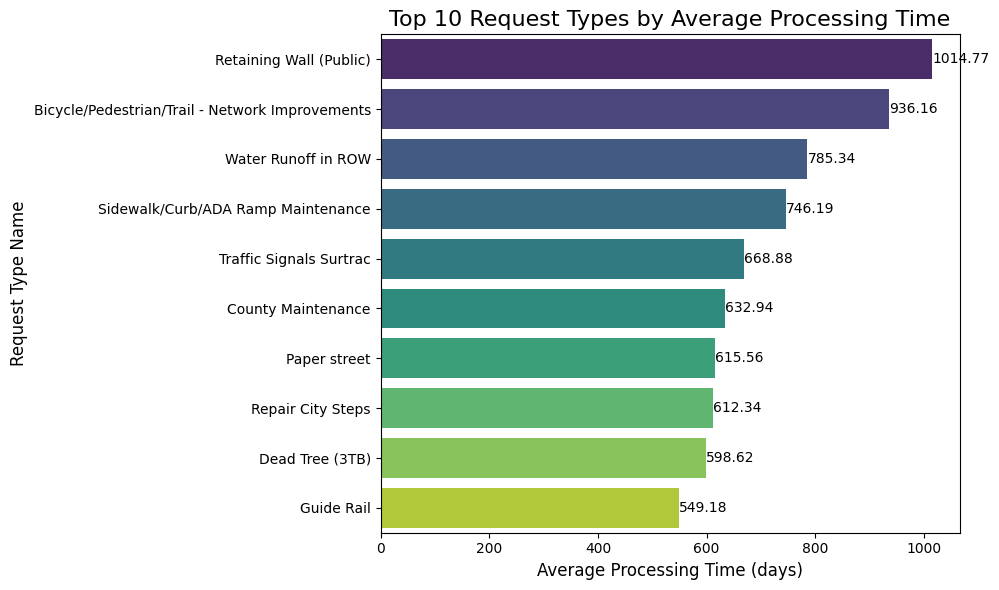

In [71]:
# Step 1: Filter top 10 request types by average processing time
top_10_request_types_avg_time = type_avg_processing_time.sort_values(by='avg_processing_time', ascending=False).head(10)

# Step 2: Plot the histogram for top 10 request types
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_request_types_avg_time,
    x='avg_processing_time',
    y='request_type_name',  # Ensure this matches the column name from your `type_avg_processing_time`
    palette='viridis'
)

# Add labels and title
plt.title('Top 10 Request Types by Average Processing Time', fontsize=16)
plt.xlabel('Average Processing Time (days)', fontsize=12)
plt.ylabel('Request Type Name', fontsize=12)

# Add average processing time labels on the bars
for index, row in enumerate(top_10_request_types_avg_time.itertuples()):
    plt.text(row.avg_processing_time + 0.1, index, f"{row.avg_processing_time:.2f}", va='center', color='black')

plt.tight_layout()
plt.show()


## Result  

#### Common Features for the Top 10 Types:  

- **Complexity**: Involves large-scale engineering projects that require detailed planning, permits, and execution.  

- **Multi-department Collaboration**: Some issues, such as county maintenance, demand coordination between multiple departments.  

- **Lower Priority**: Some types (e.g., removing dead trees) may be given lower priority compared to issues that affect a larger segment of the population.  


## Interreaction Analysis

We first take Homewood South as example as it has the highest average processing time 

C:\Users\HP\AppData\Local\Temp\ipykernel_36012\2549609122.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


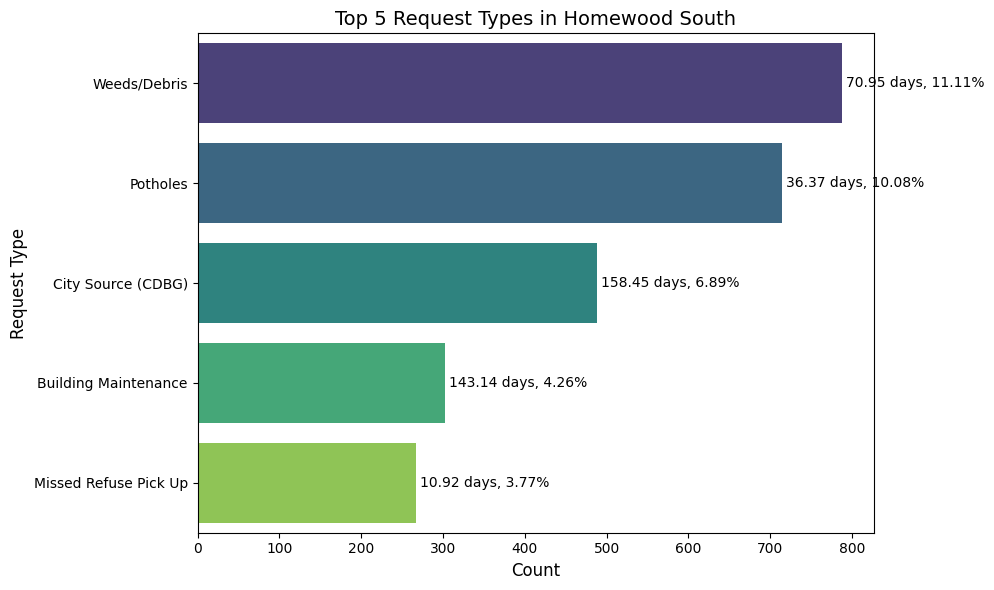

In [58]:
# interreaction analysis

# Step 1: Filter data for Homewood South
homewood_south_data = closed_requests[closed_requests['neighborhood'] == 'Homewood South']

# Step 2: Calculate the top 5 request types by count in Homewood South
top_5_types_homewood_south = (
4‘    homewood_south_data.groupby('request_type_name')
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
    .head(5)
)

# Step 3: Merge with average processing time for each type
top_5_types_homewood_south = top_5_types_homewood_south.merge(
    type_avg_processing_time, on='request_type_name', how='left'
)

# Step 4: Calculate the proportion of each type in Homewood South
total_count_homewood_south = homewood_south_data.shape[0]
top_5_types_homewood_south['proportion'] = (
    top_5_types_homewood_south['count'] / total_count_homewood_south
)

# Step 5: Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_types_homewood_south,
    x='count',
    y='request_type_name',
    palette='viridis'
)

# Add labels for processing time and proportion
for index, row in top_5_types_homewood_south.iterrows():
    plt.text(
        row['count'] + 5,  # Position to the right of the bar
        index,  # Y-axis position
        f"{row['avg_processing_time']:.2f} days, {row['proportion']:.2%}",
        va='center',
        fontsize=10,
        color='black'
    )

# Set titles and labels
plt.title('Top 5 Request Types in Homewood South', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Request Type', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


### Result
City Source with average processing time of 158.45 days and Building Maintenance with average processing time of 143.14 days may contribute for the high average processing time in Homewood South. This shows that there may be interreaction effect

## Expand that to more neighborhood
We first select the top 5 neighborhoods by average processing time and then select the top 3 request types by number for each of these five neighborhoods

In [83]:
# find interaction among neighborhood and type

# Filter requests for top 10 neighborhoods
neighborhood_avg_processing_time = closed_requests.groupby('neighborhood')['processing_time'].mean().reset_index()
neighborhood_avg_processing_time.columns = ['neighborhood', 'avg_processing_time']
top_5_neighborhoods_avg_time = neighborhood_avg_processing_time.sort_values(by='avg_processing_time', ascending=False).head(5)
top_5_requests_by_avg_time = closed_requests[closed_requests['neighborhood'].isin(top_5_neighborhoods_avg_time['neighborhood'])]

top_3_types_per_neighborhood = (
    top_5_requests_by_avg_time.groupby(['neighborhood', 'request_type_name'])  # Group by neighborhood and type
    .size()  # Count the occurrences
    .reset_index(name='count')  # Rename count column
    .sort_values(['neighborhood', 'count'], ascending=[True, False])  # Sort by neighborhood and count
    .groupby('neighborhood')  # Group by neighborhood again
    .head(3)  # Get the top 3 types for each neighborhood
)

# Calculate proportions of these types in their respective neighborhoods
neighborhood_total_counts = (
    top_5_requests_by_avg_time.groupby('neighborhood')['request_type_name']
    .count()
    .reset_index()
    .rename(columns={'request_type_name': 'total_count'})
)

# Merge with average processing time for each request type
request_type_avg_time = (
    closed_requests.groupby('request_type_name')['processing_time']
    .mean()
    .reset_index()
    .rename(columns={'processing_time': 'type_avg_time'})
)

# Add the average processing time for each type to the top 3 types data
top_3_types_per_neighborhood = top_3_types_per_neighborhood.merge(
    request_type_avg_time, on='request_type_name', how='left'
)

# Calculate the proportion of each type in its neighborhood
neighborhood_total_counts = (
    closed_requests.groupby('neighborhood')
    .size()
    .reset_index(name='total_count')
)

top_3_types_per_neighborhood = top_3_types_per_neighborhood.merge(
    neighborhood_total_counts, on='neighborhood', how='left'
)

top_3_types_per_neighborhood['proportion'] = (
    top_3_types_per_neighborhood['count'] / top_3_types_per_neighborhood['total_count']
)

# Sort the result for visualization
top_3_types_per_neighborhood = top_3_types_per_neighborhood.sort_values(
    by=['neighborhood', 'count'], ascending=[True, False]
)

# Display the top 3 types for each neighborhood
top_3_types_per_neighborhood.head(30)


,neighborhood,request_type_name,count,type_avg_time,total_count,proportion
0,Allegheny Center,Potholes,200,36.313909,2957,0.067636
1,Allegheny Center,Snow/Ice removal,178,7.448171,2957,0.060196
2,Allegheny Center,Lights,155,116.453181,2957,0.052418
3,Homewood North,Weeds/Debris,1385,70.955900,8156,0.169814
4,Homewood North,Potholes,785,36.313909,8156,0.096248
5,Homewood North,City Source (CDBG),575,158.454772,8156,0.070500
6,Homewood South,Weeds/Debris,787,70.955900,7084,0.111095
7,Homewood South,Potholes,714,36.313909,7084,0.100791
8,Homewood South,City Source (CDBG),488,158.454772,7084,0.068888
9,Homewood West,Potholes,244,36.313909,2316,0.105354


## Use Standardization Approach to analysis the inqualities among neighborhood

Remove the inherent differences in processing time caused by the varying complexity of request types, creating a fair basis for comparison across neighborhoods.

Calculate each request type's citywide average processing time and standard deviation.

Transform each request’s processing time into a z-score 


In [ ]:
# Inequities Analysis

In [5]:
from scipy.stats import zscore

# Step 1: Calculate the mean and standard deviation of processing time for each request type
request_type_stats = closed_requests.groupby('request_type_name')['processing_time'].agg(['mean', 'std']).reset_index()
request_type_stats.rename(columns={'mean': 'type_mean', 'std': 'type_std'}, inplace=True)

# Step 2: Merge these statistics back with the original dataset
normalized_data = closed_requests.merge(request_type_stats, on='request_type_name', how='left')

# Step 3: Calculate the z-score (standardized processing time)
normalized_data['standardized_processing_time'] = (
    (normalized_data['processing_time'] - normalized_data['type_mean']) / normalized_data['type_std']
)

# Step 4: Check the result
normalized_data_result = normalized_data[['neighborhood', 'request_type_name', 'processing_time',
                                          'standardized_processing_time']]


In [6]:
neighborhood_stats = normalized_data_result.groupby('neighborhood')['standardized_processing_time'].agg(['mean', 'std']).reset_index()
neighborhood_stats.rename(columns={'mean': 'avg_standardized_time', 'std': 'std_standardized_time'}, inplace=True)

# Sort by avg_standardized_time to highlight disparities
neighborhood_stats_sorted = neighborhood_stats.sort_values(by='avg_standardized_time', ascending=False)

# Display or save the results
print(neighborhood_stats_sorted)
neighborhood_stats_sorted.to_csv('neighborhood_inequality_analysis.csv', index=False)


                neighborhood  avg_standardized_time  std_standardized_time
40            Homewood North               0.154307               1.500431
41            Homewood South               0.145700               1.418749
46  Lincoln-Lemington-Belmar               0.139538               1.343630
42             Homewood West               0.139454               1.266127
65             Regent Square               0.126304               1.490091
..                       ...                    ...                    ...
23          Crawford-Roberts              -0.066971               0.760809
58                   Oakwood              -0.075259               0.711081
71          South Side Flats              -0.080149               0.846852
66                 Ridgemont              -0.114813               0.589708
22           Crafton Heights              -0.124681               0.749873

[90 rows x 3 columns]


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\92101052.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


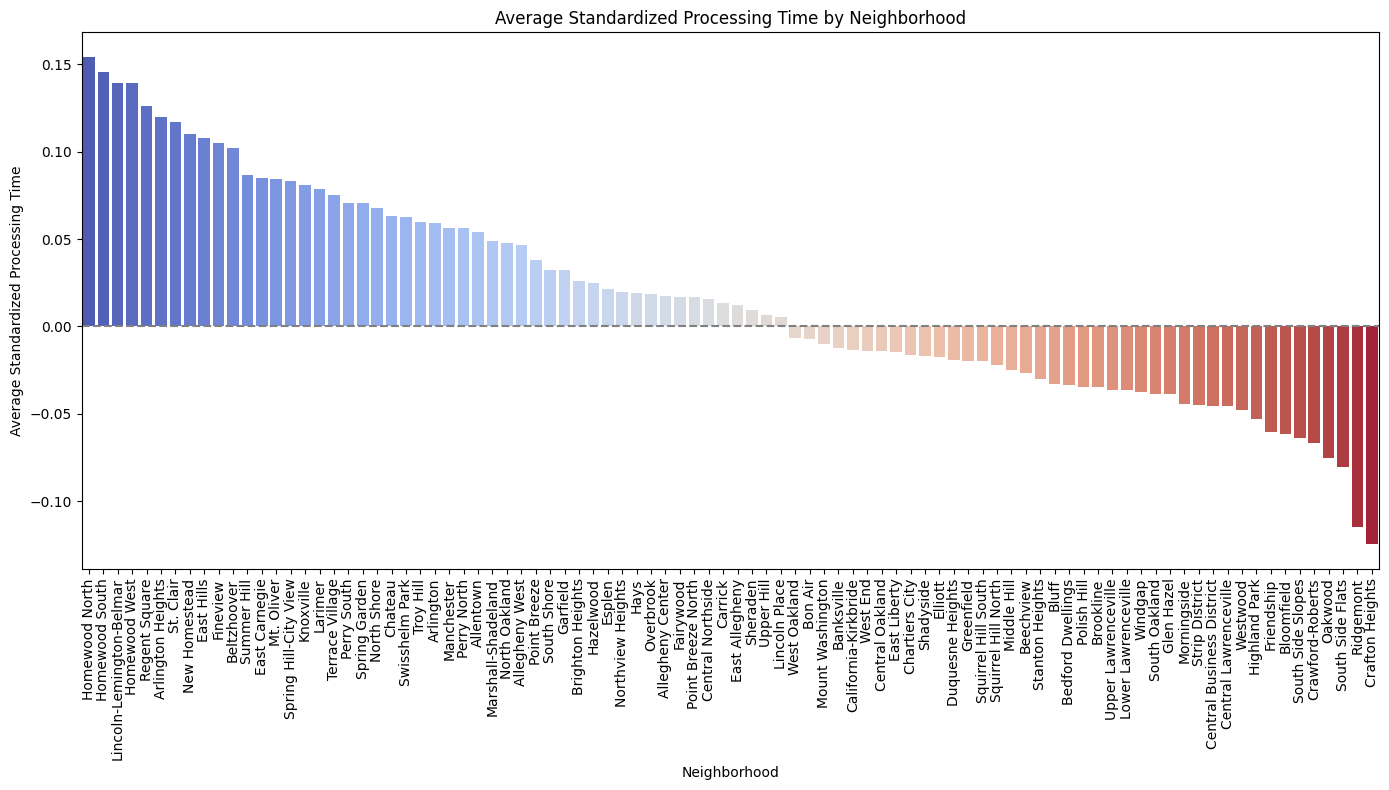

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean standardized processing time by neighborhood
mean_std_time_by_neighborhood = normalized_data_result.groupby('neighborhood')['standardized_processing_time'].mean().reset_index()
mean_std_time_by_neighborhood = mean_std_time_by_neighborhood.sort_values(by='standardized_processing_time', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=mean_std_time_by_neighborhood,
    x='neighborhood',
    y='standardized_processing_time',
    palette='coolwarm'
)
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0 for reference
plt.xticks(rotation=90)
plt.title('Average Standardized Processing Time by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Standardized Processing Time')
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_36012\1019507384.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


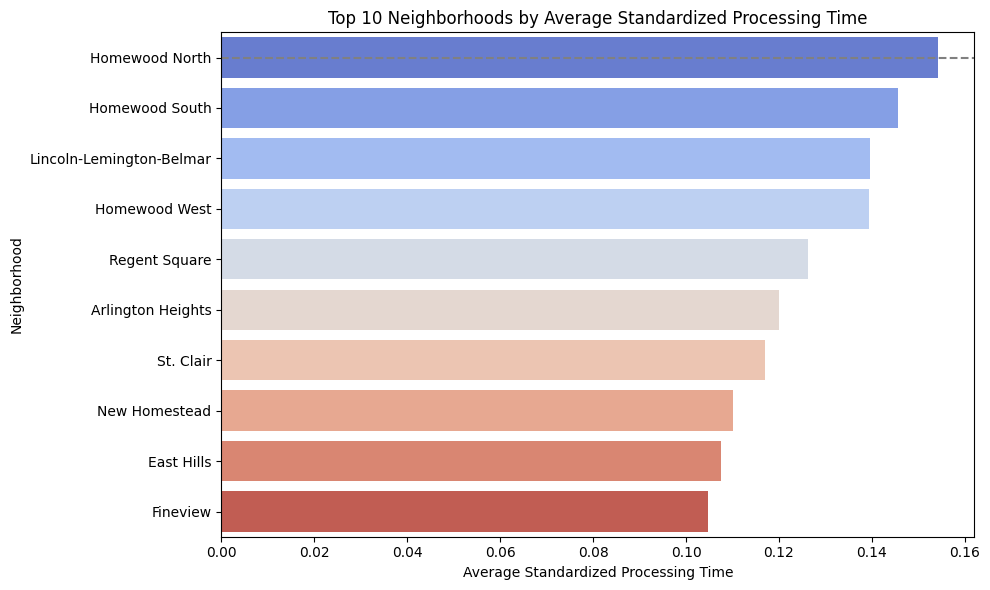

In [93]:
# Calculate mean standardized processing time by neighborhood
mean_std_time_by_neighborhood = normalized_data_result.groupby('neighborhood')['standardized_processing_time'].mean().reset_index()
top_10_mean_std_time = mean_std_time_by_neighborhood.nlargest(10, 'standardized_processing_time')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_mean_std_time,
    x='standardized_processing_time',
    y='neighborhood',
    palette='coolwarm'
)
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0
plt.title('Top 10 Neighborhoods by Average Standardized Processing Time')
plt.xlabel('Average Standardized Processing Time')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

## Result
As observed, many neighborhoods with the highest average processing times also appear in the standardized results. Notably, Homewood stands out, indicating that the prolonged average processing times in these neighborhoods are attributed to both systemic inequalities among neighborhoods and the distribution of request types.

### Heatmap

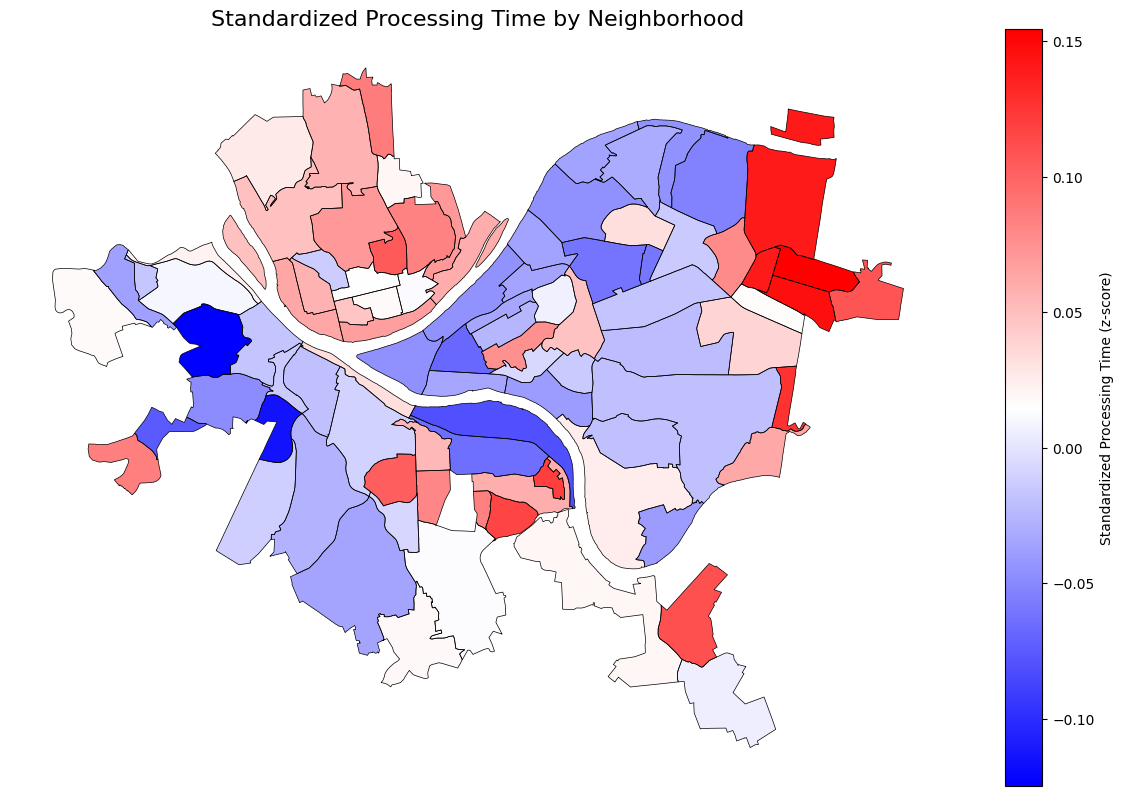

In [94]:
# Heatmap for Standardized Processing Time
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Calculate mean standardized processing time by neighborhood
std_time_by_neighborhood = normalized_data_result.groupby('neighborhood')['standardized_processing_time'].mean().reset_index()

# Step 2: Merge standardized processing time data with neighborhood boundaries
merged_std_gdf = neighborhoods_gdf.merge(std_time_by_neighborhood, left_on='hood', right_on='neighborhood', how='inner')

# Step 3: Create a new colormap for standardized processing time
std_colormap = LinearSegmentedColormap.from_list('StandardizedTime', ['blue', 'white', 'red'])

# Step 4: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot all neighborhoods as a heatmap using standardized processing time
merged_std_gdf.plot(
    column='standardized_processing_time',
    cmap=std_colormap,
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "Standardized Processing Time (z-score)", 
        'orientation': 'vertical'
    }
)

# Plot neighborhood boundaries for reference
neighborhoods_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Title and layout adjustments
plt.title("Standardized Processing Time by Neighborhood", fontsize=16)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()


## Prediction Model Set Up

#### The goal of this model is to predict processing time (target variable) based on 
#### neighborhood and request type (predictor variables).​

### Load and clean the population data

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

# Step 1: Load and clean population data
population_data = pd.read_csv('neighborhood_population.csv', usecols=['Neighborhood', '2020_Total_Population'])
population_data.rename(columns={'Neighborhood': 'neighborhood', '2020_Total_Population': 'population'}, inplace=True)
top_10_population_neighborhoods = population_data.sort_values(by='population', ascending=False).head(10)
print("Top 10 neighborhoods by population:")
print(top_10_population_neighborhoods)

Top 10 neighborhoods by population:
           neighborhood  population
75  Squirrel Hill South       15317
66            Shadyside       15317
12            Brookline       13063
74  Squirrel Hill North       11879
54        North Oakland       10691
14              Carrick       10290
51     Mount Washington        8710
8            Bloomfield        8665
6             Beechview        7596
70     South Side Flats        7467


## model simplx

#### For a simplex model, We only choose top 10 neighborhoods by population and top 10 request types by count to get enough data​

In [31]:
# Step 2: Filter closed_requests to include only neighborhoods in top_10_population_neighborhoods
filtered_requests_top_population = closed_requests[
    closed_requests['neighborhood'].isin(top_10_population_neighborhoods['neighborhood'])
]
#print(filtered_requests_top_population)

In [32]:
# Step 3: Group by 'request_type_name' and count the number of occurrences
top_10_request_types = (
    closed_requests['request_type_name']
    .value_counts()
    .head(10)
    .reset_index()
)
# Rename columns for clarity
top_10_request_types.columns = ['request_type_name', 'count']
print(top_10_request_types)

          request_type_name  count
0                  Potholes  65466
1              Weeds/Debris  64316
2     Missed Refuse Pick Up  39205
3          Snow/Ice removal  29712
4         Refuse Violations  24414
5      Building Maintenance  21477
6           Illegal Parking  16499
7   Litter, Public Property  16471
8     Street Light - Repair  16461
9  Missed Recycling Pick Up  16246


In [34]:
# Step 4: Extract the top 10 request type names from top_10_request_types
top_10_types = top_10_request_types['request_type_name']

# Filter rows in filtered_requests_top_population where request_type_name is in top_10_types
filtered_top_requests = filtered_requests_top_population[
    filtered_requests_top_population['request_type_name'].isin(top_10_types)
]
# Display the result
print(filtered_top_requests)

# save file as model data
filtered_top_requests.to_csv('model_data.csv', index=False)

           _id  group_id  num_requests parent_closed status_name  status_code  \
364      61202    875141             1             t      closed            1   
373      61467    887096             2             t      closed            1   
375      61532    887387             1             t      closed            1   
377      61563    883964             1             t      closed            1   
380      61622    879260             1             t      closed            1   
...        ...       ...           ...           ...         ...          ...   
667904  791471    903291             1             t      closed            1   
667905  791482    902213             1             t      closed            1   
667908  791491    901778             1             t      closed            1   
667909  791494    903309             1             t      closed            1   
667914  791507    897913             1             t      closed            1   

                           

#### Delete the outliers

In [36]:
# Step 5: Define the function to remove outliers using the IQR method
model_data = pd.read_csv('model_data.csv')
def remove_outliers(group):
    q1 = group['processing_time'].quantile(0.25)  # First quartile
    q3 = group['processing_time'].quantile(0.75)  # Third quartile
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return group[(group['processing_time'] >= lower_bound) & (group['processing_time'] <= upper_bound)]

# Apply the function to filter outliers
cleaned_data = (
    model_data.groupby(['neighborhood', 'request_type_name'])
    .apply(remove_outliers)
    .reset_index(drop=True)  # Reset index to flatten the result
)
print(cleaned_data)

          _id  group_id  num_requests parent_closed status_name  status_code  \
0       88447    835296             1             t      closed            1   
1      271941    349626             1             t      closed            1   
2      272263    314080             1             t      closed            1   
3      272327     35470             1             t      closed            1   
4      274400    308458             1             t      closed            1   
...       ...       ...           ...           ...         ...          ...   
90612  784517    890527             1             t      closed            1   
90613  785469    891516             1             t      closed            1   
90614  785470    891518             1             t      closed            1   
90615  785479    891530             1             t      closed            1   
90616  789184    898917             1             t      closed            1   

                                    dep

C:\Users\HP\AppData\Local\Temp\ipykernel_4588\1350447028.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_outliers)


## Model Improvement

#### Delete the outliers and then use log to normalize the processing time

In [37]:
# improvement1: Take logarithmic transformation to reduce skewness
cleaned_data['processing_time'] = np.log1p(cleaned_data['processing_time'])

# improvement 2: add interreaction variables
cleaned_data['interaction'] = cleaned_data['neighborhood'] + "_" + cleaned_data['request_type_name']

We Use **<span style="color:red">linear regression model</span>**  
- Linear regression requires numerical inputs.
  
We Use **<span style="color:red">One-Hot Encoding</span>**  
- Converts categorical variables into a numerical format by creating binary (0/1) columns for each category.  
- Avoid assigning arbitrary numerical values to categories, which could mislead the model.  

The data is split into **training (80%)** and **testing (20%)** sets.  


In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# OneHotEncoder encodes categorical variables (including interaction terms)
features = ['neighborhood', 'request_type_name', 'interaction']
target = 'processing_time'

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(cleaned_data[features])
encoded_feature_names = encoder.get_feature_names_out(features)

# transfer to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Define target variable
y = cleaned_data[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Step 7:  Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance (coefficients)
feature_coefficients = pd.DataFrame({
    'feature': encoded_feature_names,
    'coefficient': model.coef_
}).sort_values(by='coefficient', ascending=False)

print("Feature Coefficients:")
print(feature_coefficients)

Mean Squared Error (MSE): 0.1981
Mean Absolute Error (MAE): 0.3638
R² Score: 0.2723
Feature Coefficients:
                                               feature   coefficient
19                      request_type_name_Weeds/Debris  1.056891e+12
9                     neighborhood_Squirrel Hill South  9.994118e+11
98   interaction_South Side Flats_Street Light - Re...  4.058866e+11
68   interaction_Mount Washington_Street Light - Re...  3.607988e+11
108  interaction_Squirrel Hill North_Street Light -...  3.437240e+11
..                                                 ...           ...
59                    interaction_Carrick_Weeds/Debris -1.090726e+12
110  interaction_Squirrel Hill South_Building Maint... -1.131053e+12
117   interaction_Squirrel Hill South_Snow/Ice removal -1.189668e+12
112  interaction_Squirrel Hill South_Litter, Public... -1.262573e+12
119       interaction_Squirrel Hill South_Weeds/Debris -1.987497e+12

[120 rows x 2 columns]


## Model Performance

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

# Step 1: Take logarithmic transformation to reduce skewness
closed_requests['processing_time'] = np.log1p(closed_requests['processing_time'])

# Step 2: Add interaction variables
closed_requests['interaction'] = closed_requests['neighborhood'] + "_" + closed_requests['request_type_name']

# Step 3: OneHotEncode categorical variables (including interaction terms)
features = ['neighborhood', 'request_type_name', 'interaction']
target = 'processing_time'

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(cleaned_data[features])
encoded_feature_names = encoder.get_feature_names_out(features)

# Step 4: Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Step 5: Prepare the target variable
y = cleaned_data[target]

# Step 6: Combine features and target into one DataFrame for statsmodels
X = encoded_df
X['Intercept'] = 1  # Add intercept manually for statsmodels
X_with_intercept = sm.add_constant(X)  # Alternatively, add constant with statsmodels
model_data = pd.concat([X_with_intercept, y], axis=1)

# Step 7: Fit the linear regression model using statsmodels
model = sm.OLS(y, X_with_intercept).fit()

# Step 8: Get the summary of the model, including p-values
summary = model.summary()
print(summary)

# Step 9: Extract coefficients and p-values
coefficients = pd.DataFrame({
    'feature': X_with_intercept.columns,
    'coefficient': model.params,
    'p-value': model.pvalues
}).sort_values(by='coefficient', ascending=False)

print("Feature Coefficients with P-values:")
print(coefficients)


                            OLS Regression Results                            
Dep. Variable:        processing_time   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     356.0
Date:                Thu, 05 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:09:17   Log-Likelihood:                -54667.
No. Observations:               90617   AIC:                         1.095e+05
Df Residuals:                   90516   BIC:                         1.105e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

## Result  
1. **Model Fit**:  
   - The R-squared value is **0.282**, indicating that approximately **28.2%** of the variance in processing time is explained by the model.  
   - The **Adjusted R-squared** remains consistent at **0.282**, suggesting a relatively stable model fit despite the inclusion of 100 predictors.  

2. **Significant Features**:  
   - Several interaction terms between specific neighborhoods and request types have **significant coefficients** with p-values less than **0.05**, suggesting that processing time is influenced by both geographic and categorical factors.  
   - Notable significant features include:  
     - **Squirrel Hill North** interactions with request types (e.g., Refuse Violations, Missed Recycling Pick Up) show **large positive coefficients**, indicating longer processing times.  
     - **South Side Flats** interactions with request types like **Snow/Ice Removal** and **Street Light Repair** exhibit **large negative coefficients**, suggesting shorter processing times.  

3. **Multicollinearity Concerns**:  
   - The condition number (**1.73e+15**) and the note about the smallest eigenvalue (**3.87e-26**) highlight potential **multicollinearity** issues, which may arise from overlapping predictors or redundant features.  

4. **Neighborhood Effects**:  
   - **Squirrel Hill North** stands out with a notably high positive coefficient, indicating longer processing times overall.  

These results suggest that both **geographic inequalities** and the **distribution of request types** significantly impact processing time. The presence of multicollinearity requires further investigation or dimensionality reduction for a more robust model.  


In [40]:
# Step 10: Filter significant features based on p-value
significant_features = coefficients[coefficients['p-value'] < 0.05]

# Step 11: Sort significant features by the absolute value of their coefficients
top_significant_features = significant_features.reindex(significant_features['coefficient'].abs().sort_values(ascending=False).index)

# Display the top significant features
print("Top Significant Features:")
print(top_significant_features)


Top Significant Features:
                                                                                              feature  \
interaction_Squirrel Hill North_Refuse Violations   interaction_Squirrel Hill North_Refuse Violations   
interaction_Squirrel Hill North_Missed Recyclin...  interaction_Squirrel Hill North_Missed Recycli...   
interaction_Squirrel Hill North_Potholes                     interaction_Squirrel Hill North_Potholes   
interaction_Squirrel Hill North_Weeds/Debris             interaction_Squirrel Hill North_Weeds/Debris   
interaction_Squirrel Hill North_Litter, Public ...  interaction_Squirrel Hill North_Litter, Public...   
interaction_Squirrel Hill North_Missed Refuse P...  interaction_Squirrel Hill North_Missed Refuse ...   
interaction_Squirrel Hill North_Building Mainte...  interaction_Squirrel Hill North_Building Maint...   
interaction_Squirrel Hill North_Snow/Ice removal     interaction_Squirrel Hill North_Snow/Ice removal   
interaction_Squirrel Hill Nor

## Future Improvement  

### Feature Engineering  
- Introduce meaningful features (e.g., economic level,police resource, education resource).  

### Explore Nonlinear Models  
- Random Forest  
- Support Vector Machines or Neural Networks for capturing complex nonlinear relationships.  
